In [1]:
import os
import sqlite3
import csv

conn = sqlite3.connect('example.db')

c = conn.cursor()

# How many rows are affected by an operation?

print("rows are affected by an operation")
seq_id = 35
for x in c.execute("select count(1) from (select distinct * from (SELECT old_row FROM ROW_CHANGES WHERE seq_id=? union SELECT row_id from cell_changes where seq_id=?))",(str(seq_id),str(seq_id))):
    print(x)

#- [ ]  How many columns are affected/produced by an operation?
print("cols are affected by an operation")
seq_id = 35
for x in c.execute("select count(1) from (select distinct * from (SELECT old_col FROM COL_CHANGES WHERE seq_id=? union SELECT cell_id from cell_changes where seq_id=?))",(str(seq_id),str(seq_id))):
    print(x)

#- [ ]  How many rows are affected on a certain range of operations (multiple operations)?
print("rows are affected by range of operations")
seq_id_first = 7
seq_id_last = 25
for x in c.execute("select count(1) from (select distinct * from (SELECT old_row FROM ROW_CHANGES WHERE seq_id>=? and seq_id<=? union SELECT row_id from cell_changes where seq_id>=? and seq_id<=?))",(str(seq_id_first),str(seq_id_last),str(seq_id_first),str(seq_id_last))):
    print(x)


#- [ ]  How many columns are affected/produced by a certain range of operations?

print("cells are affected by range of operations")
seq_id_first = 7
seq_id_last = 25
for x in c.execute("select count(1) from (select distinct * from (SELECT old_col FROM COL_CHANGES WHERE seq_id>=? and seq_id<=? union SELECT cell_id from cell_changes where seq_id>=? and seq_id<=?))",(str(seq_id_first),str(seq_id_last),str(seq_id_first),str(seq_id_last))):
    print(x)


#- [ ]  What are the dependencies (input) of an operation?
print("columns dependencies are affected by an operation")
seq_id = 18
for x in c.execute("""
select count(1) from (select distinct col_dep from col_dependency where seq_id=?)
""",(str(seq_id),)):
    print(x)

#- [ ]  What are the dependencies for a range of operations?
print("columns dependencies are affected by range of operation")
seq_id_first = 7
seq_id_last = 25
for x in c.execute("""
select count(1) from (select distinct col_dep from col_dependency where seq_id>=? and seq_id<=?)
""",(str(seq_id_first),str(seq_id_last))):
    print(x)

#- [ ]  What operations are dependency of an operation?
print("What operations are dependency of an operation?")

seq_id = 35
q1 = c.execute("""
select cell_id from cell_changes where seq_id = ?
UNION
select new_col from col_changes where seq_id = ?
UNION
select col_dep from col_dependency where seq_id = ?
""",(str(seq_id),str(seq_id),str(seq_id)))

def get_parents(seq_id,cell_id,new_seq_id=999999,old_col=-1):
    col_id = cell_id
    #print(col_id)
    q2 = c.execute("""
    select seq_id,old_col from col_changes where new_col=? and seq_id>=? order by seq_id desc limit 1
    """,(str(col_id),str(seq_id)))
    #print(seq_id)
    #new_seq_id = 9999999
    for y in q2:
        new_seq_id = y[0]
        old_col = y[1]

    q3 = c.execute("""select distinct * from(
    select seq_id,op_name from cell_changes where seq_id < ? and seq_id > ? and cell_id=?
    union
    select seq_id,op_name from col_dependency where seq_id < ?  and seq_id > ? and col=?
    )
    """,(new_seq_id,seq_id,col_id,new_seq_id,seq_id,col_id))
    all_ops = [y for y in q3]
    #print(all_ops)
    q4 = c.execute("""    
    select seq_id,col_dep from col_dependency where seq_id < ?  and seq_id > ? and col=?
    """,(new_seq_id,seq_id,col_id))

    for y in q4:
        all_ops =  all_ops + get_parents(y[0],y[1],new_seq_id,old_col)

    if new_seq_id!=999999:
        all_ops = all_ops + get_parents(new_seq_id,old_col)

    return all_ops 
    #print([y for y in q3])

for x in q1:
    # get the first col_changes
    col_id = x[0]
    print(get_parents(seq_id,x[0]))

    '''
    q2 = c.execute("""
    select seq_id,new_col from col_changes where new_col=? and seq_id>=? order by seq_id desc limit 1
    """,(str(col_id),str(seq_id)))
    new_seq_id = 9999999
    for y in q2:
        new_seq_id = y[0]
        new_col = y[1]
    q3 = c.execute("""select distinct * from(
    select seq_id,op_name from cell_changes where seq_id < ? and seq_id > ? and cell_id=?
    union
    select seq_id,op_name from col_dependency where seq_id < ?  and seq_id > ? and col=?
    )
    """,(new_seq_id,seq_id,col_id,new_seq_id,seq_id,col_id))
    print([y for y in q3])
    '''

#- [ ]  What operations are affected by an operation?

print("What operations are affected by an operation?")

seq_id = 35
q1 = c.execute("""
select cell_id from cell_changes where seq_id = ?
UNION
select new_col from col_changes where seq_id = ?
UNION
select col_dep from col_dependency where seq_id = ?
""",(str(seq_id),str(seq_id),str(seq_id)))


def get_childrens(seq_id,cell_id,new_seq_id=-1,new_col=-1):
    col_id = cell_id
    #print(col_id)
    q2 = c.execute("""
    select seq_id,new_col from col_changes where old_col=? and seq_id<=? order by seq_id desc limit 1
    """,(str(col_id),str(seq_id)))
    #print(seq_id)
    #new_seq_id = 9999999
    for y in q2:
        new_seq_id = y[0]
        new_col = y[1]

    q3 = c.execute("""select distinct * from(
    select seq_id,op_name from cell_changes where seq_id > ? and seq_id < ? and cell_id=?
    union
    select seq_id,op_name from col_dependency where seq_id > ?  and seq_id < ? and col_dep=?
    )
    """,(new_seq_id,seq_id,col_id,new_seq_id,seq_id,col_id))
    all_ops = [y for y in q3]
    #print(all_ops)
    q4 = c.execute("""    
    select seq_id,col_dep from col_dependency where seq_id > ?  and seq_id < ? and col=?
    """,(new_seq_id,seq_id,col_id))

    for y in q4:
        all_ops =  all_ops + get_parents(y[0],y[1],new_seq_id,new_col)

    if new_seq_id!=-1:
        all_ops = all_ops + get_parents(new_seq_id,new_col)

    return all_ops 
    #print([y for y in q3])

for x in q1:
    # get the first col_changes
    print(get_childrens(seq_id,x[0]))

    '''
    col_id = x[0]
    q2 = c.execute("""
    select seq_id,new_col from col_changes where old_col=? and seq_id<=? order by seq_id desc limit 1
    """,(str(col_id),str(seq_id)))
    new_seq_id = -1
    for y in q2:
        new_seq_id = y[0]
        new_col = y[1]
    q3 = c.execute("""select distinct * from(
    select seq_id,op_name from cell_changes where seq_id > ? and seq_id < ? and cell_id=?
    union
    select seq_id,op_name from col_dependency where seq_id > ?  and seq_id < ? and col_dep=?
    )
    """,(new_seq_id,seq_id,col_id,new_seq_id,seq_id,col_id))
    print([y for y in q3])
    '''


from or_extract import extract_project,read_dataset,search_cell_column
file_name = "airbnb_dirty-csv.openrefine.tar.gz"
locex,_ = extract_project(file_name)
# extract data
dataset = read_dataset(locex)

#- [ ]  How the value on a cell was constructed (history of a cell)?
col_id = 23
#row_id = 456
row_id = 65
start_seq = 0
# select the first column / row changes for anchor
print("history of a cell")

def forward_history(col_id,row_id,start_seq,start_row_id=None,old_cell=None,trace_dependency=True):
    #print("cell trace",col_id,row_id,start_seq)
    if start_row_id==None:
        start_row_id = row_id
            
    q1 = c.execute("""
    select * from (
    select seq_id,new_col,'col_changes',history_id,op_name from col_changes where old_col = ? and seq_id<=?
    UNION
    select seq_id,new_row,'row_changes',history_id,op_name from row_changes where old_row = ? and seq_id<=?
    ) 
    order by seq_id desc limit 1
    """,(str(col_id),str(start_seq),str(row_id),str(start_seq)))

    xx = [x for x in q1]
    #print("xx",xx)

    if len(xx)>0:
        xx = xx[0]        
        #print(xx)
        change_seq = xx[0]
        change_cc = xx[1]
        change_type = xx[2]
    else:
        change_seq = 0
        change_type = None

    q2 = c.execute("""
    select * from cell_changes where cell_id=? and row_id=? and seq_id>? and seq_id<=? order by seq_id desc
    """,(str(col_id),str(row_id),str(change_seq),str(start_seq)))
    q2 = [x for x in q2]

    #all_result = [x for x in q2]
    new_cell = (col_id,row_id)

    all_result = []
    for x in q2:
        #all_result.append(("value_change",x))
        all_result.append((x,(x[0],old_cell,new_cell)))
        #all_result.append(("coord_change",x))
        #print(x[0],old_cell,new_cell)
    
    if len(q2)==0:
        #all_result.append(("coord_change",(start_seq,old_cell,new_cell)))
        all_result.append(("",(start_seq,old_cell,new_cell)))

    #print(start_seq,old_cell,new_cell)

    #elif latest_value=="":
    # first time, no change on cell_changes, set latest_value as

    if trace_dependency:
        q3 = c.execute("""
        select col from col_dependency where col_dep=? and seq_id>=? and seq_id<? order by seq_id desc
        """,(str(col_id),str(change_seq),str(start_seq)))

        #print("seq_dep",[x for x in q3])
        for x in q3:
            print("column dependency:",x[0])
            #all_result = all_result + history_cell(x[0],row_id,change_seq)
            all_result = all_result + forward_history(x[0],start_row_id,start_seq,start_row_id=start_row_id,old_cell=new_cell)

    if change_type=="col_changes":
        col_id = change_cc
        #print("col_changes:",col_id,row_id,latest_value)        
    elif change_type=="row_changes":
        row_id = change_cc
        #print("row_changes:",col_id,row_id,latest_value)        
        #print([x for x in q1]        
    else:
        pass

    old_cell = (col_id,row_id)

    # dependency for the column

    if change_seq>0:
        all_result = all_result + forward_history(col_id,row_id,change_seq-1,start_row_id=start_row_id,old_cell=new_cell)
    else:
        print(start_seq-1,new_cell,old_cell)
        if len(q2) == 0:
            all_result.append(("",(start_seq-1,new_cell,old_cell)))
            #all_result.append(("coord_change",(start_seq-1,new_cell,old_cell)))

    
    return all_result

print("forward_history",forward_history(22,7149,27,trace_dependency=False))

def history_cell(col_id,row_id,start_seq=0,latest_value="",start_row_id=None,old_cell=None):
    #print("cell trace",col_id,row_id,start_seq)
    if start_row_id==None:
        start_row_id = row_id

    if latest_value=="":
    #if start_seq==0:
        latest_value = dataset[2]["rows"][int(row_id)]["cells"][int(col_id)]
        #print("cell trace",col_id,row_id,start_seq,"latest value:",latest_value)
    
    #if old_cell == None:
    #    old_cell = (col_id,row_id,latest_value)
            
    x, y = search_cell_column(dataset[0]["cols"],col_id)
    #print(min(dataset[2]["rows"].keys()))
    #print("cell trace",col_id,row_id,start_seq,"latest value:",dataset[2]["rows"][int(row_id)]["cells"][int(col_id)])
    q1 = c.execute("""
    select * from (
    select seq_id,old_col,'col_changes',history_id,op_name from col_changes where new_col = ? and seq_id>=?
    UNION
    select seq_id,old_row,'row_changes',history_id,op_name from row_changes where new_row = ? and seq_id>=?
    ) 
    order by seq_id asc limit 1
    """,(str(col_id),str(start_seq),str(row_id),str(start_seq)))

    xx = [x for x in q1]
    if len(xx)>0:
        xx = xx[0]        
        #print(xx)
        change_seq = xx[0]
        change_cc = xx[1]
        change_type = xx[2]
    else:
        change_seq = 9999999
        change_type = None

    q2 = c.execute("""
    select * from cell_changes where cell_id=? and row_id=? and seq_id>=? and seq_id<? order by seq_id asc
    """,(str(col_id),str(row_id),str(start_seq),str(change_seq)))
    
    
    all_result = [x for x in q2]
    #print(all_result)

    if len(all_result)>0:
        latest_value = all_result[-1][6]
        #print("cell trace",col_id,row_id,start_seq,"latest value:",latest_value)
    #else:
    #    all_result = all_result + [(start_seq,"","",col_id,row_id,latest_value)]

    new_cell = (col_id,row_id,latest_value)

    print(old_cell,new_cell)

    #elif latest_value=="":
    # first time, no change on cell_changes, set latest_value as

    q3 = c.execute("""
    select col_dep from col_dependency where col=? and seq_id>=? and seq_id<? order by seq_id asc
    """,(str(col_id),str(start_seq),str(change_seq)))

    #print("seq_dep",[x for x in q3])
    for x in q3:
        print("column dependency:",x[0])
        #all_result = all_result + history_cell(x[0],row_id,change_seq)
        try:
            forward_res = forward_history(x[0],row_id,start_seq)[-1]
        except:
            break
        
        print(forward_res)
        #all_result = all_result + history_cell(x[0],start_row_id,0,start_row_id=start_row_id,old_cell=new_cell)
        all_result = all_result + history_cell(forward_res[1][2][0],forward_res[1][2][1],0,start_row_id=start_row_id,old_cell=new_cell)

    if change_type=="col_changes":
        col_id = change_cc
        #print("col_changes:",col_id,row_id,latest_value)        
    elif change_type=="row_changes":
        row_id = change_cc
        #print("row_changes:",col_id,row_id,latest_value)        
        #print([x for x in q1]        
    else:
        pass
    if len(xx)>0:
        print(list(xx) + [latest_value])        

    # dependency for the column

    if change_seq!=9999999:
        all_result = all_result + history_cell(col_id,row_id,change_seq+1,latest_value,start_row_id=start_row_id,old_cell=new_cell)

    return all_result

print("\n".join([str(x) for x in history_cell(col_id,row_id)]))

rows are affected by an operation
(6,)
cols are affected by an operation
(1,)
rows are affected by range of operations
(7572,)
cells are affected by range of operations
(5,)
columns dependencies are affected by an operation
(0,)
columns dependencies are affected by range of operation
(3,)
What operations are dependency of an operation?
[(36, &#39;com.google.refine.model.changes.ColumnAdditionChange&#39;), (38, &#39;com.google.refine.model.changes.ColumnAdditionChange&#39;), (39, &#39;com.google.refine.model.changes.MassCellChange&#39;), (40, &#39;com.google.refine.model.changes.ColumnAdditionChange&#39;)]
What operations are affected by an operation?
[(4, &#39;com.google.refine.model.changes.RowReorderChange&#39;), (5, &#39;com.google.refine.model.changes.RowReorderChange&#39;), (32, &#39;com.google.refine.model.changes.MassCellChange&#39;), (33, &#39;com.google.refine.model.changes.MassCellChange&#39;), (34, &#39;com.google.refine.model.changes.MassCellChange&#39;)]
[Errno 17] File ex

In [2]:
from networkx import nx

In [19]:
all_recipe = {}
for x in c.execute("""select * from recipe_changes"""):
    all_recipe[x[0]] = (x[2],x[2].split(".")[-1])
    #print(x[0],x[1],x[2])
print(all_recipe)

{0: (&#39;com.google.refine.model.changes.RowRemovalChange&#39;, &#39;RowRemovalChange&#39;), 1: (&#39;com.google.refine.model.changes.RowStarChange&#39;, &#39;RowStarChange&#39;), 2: (&#39;com.google.refine.model.changes.RowStarChange&#39;, &#39;RowStarChange&#39;), 3: (&#39;com.google.refine.model.changes.CellChange&#39;, &#39;CellChange&#39;), 4: (&#39;com.google.refine.model.changes.RowReorderChange&#39;, &#39;RowReorderChange&#39;), 5: (&#39;com.google.refine.model.changes.RowReorderChange&#39;, &#39;RowReorderChange&#39;), 6: (&#39;com.google.refine.model.changes.ColumnMoveChange&#39;, &#39;ColumnMoveChange&#39;), 7: (&#39;com.google.refine.model.changes.CellChange&#39;, &#39;CellChange&#39;), 8: (&#39;com.google.refine.model.changes.ColumnRenameChange&#39;, &#39;ColumnRenameChange&#39;), 9: (&#39;com.google.refine.model.changes.MassCellChange&#39;, &#39;MassCellChange&#39;), 10: (&#39;com.google.refine.model.changes.MassCellChange&#39;, &#39;MassCellChange&#39;), 11: (&#39;com.g

In [67]:
def history_cell(col_id,row_id,start_seq=0,latest_value="",start_row_id=None,old_cell=None,ngraph=None,temp_cell=None):
    #print("cell trace",col_id,row_id,start_seq)
    if start_row_id==None:
        start_row_id = row_id

    old_value = latest_value
    if latest_value=="":
    #if start_seq==0:
        old_value = latest_value    
        latest_value = dataset[2]["rows"][int(row_id)]["cells"][int(col_id)]
        #print("cell trace",col_id,row_id,start_seq,"latest value:",latest_value)
    
    #if old_cell == None:
    #    old_cell = (col_id,row_id,latest_value)
            
    x, y = search_cell_column(dataset[0]["cols"],col_id)
    #print(min(dataset[2]["rows"].keys()))
    #print("cell trace",col_id,row_id,start_seq,"latest value:",dataset[2]["rows"][int(row_id)]["cells"][int(col_id)])
    q1 = c.execute("""
    select * from (
    select seq_id,old_col,'col_changes',history_id,op_name from col_changes where new_col = ? and seq_id>=?
    UNION
    select seq_id,old_row,'row_changes',history_id,op_name from row_changes where new_row = ? and seq_id>=?
    ) 
    order by seq_id asc limit 1
    """,(str(col_id),str(start_seq),str(row_id),str(start_seq)))

    xx = [x for x in q1]
    if len(xx)>0:
        xx = xx[0]        
        #print(xx)
        change_seq = xx[0]
        change_cc = xx[1]
        change_type = xx[2]
        op_name = xx[4]
    else:
        change_seq = 9999999
        change_type = None
        op_name = ""

    q2 = c.execute("""
    select * from cell_changes where cell_id=? and row_id=? and seq_id>=? and seq_id<? order by seq_id asc
    """,(str(col_id),str(row_id),str(start_seq),str(change_seq)))
    
    
    all_result = [x for x in q2]
    #print(all_result)

    if len(all_result)>0:
        old_value = latest_value
        latest_value = all_result[-1][6]
        #print("cell trace",col_id,row_id,start_seq,"latest value:",latest_value)
    #else:
    #    all_result = all_result + [(start_seq,"","",col_id,row_id,latest_value)]
        print("tcell",temp_cell)
        if temp_cell!=None:
            print("tt5",(temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1]),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1]),old_value,latest_value)
            ngraph.add_edge((temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1]),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1]))
        for j,x in enumerate(all_result):
            if (j==0) & (temp_cell!=None):
                print("tt6",(x[0],x[4],x[3],all_recipe[x[0]][1]),(temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1]),old_value,latest_value)
                ngraph.add_edge((x[0],x[4],x[3],all_recipe[x[0]][1]),(temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1]))
            else:
                print("tt3",(x[0],x[4],x[3],all_recipe[x[0]][1]),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1]),old_value,latest_value)
                ngraph.add_edge((x[0],x[4],x[3],all_recipe[x[0]][1]),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1]))
            old_cell = (x[0],x[4],x[3],x[6],x[2])
            #change_seq = x[0]
            #col_id = x[4]
            #row_id = x[3]
            #latest_value = x[6]
        new_cell = old_cell
    else:
        new_cell = (change_seq,col_id,row_id,latest_value,op_name)

    print("moving cell",old_cell,new_cell)
    if ngraph!=None:        
        if (old_cell!=None) & (start_seq>0):
            #ngraph.add_edge((old_cell[0],old_cell[1]),(new_cell[0],new_cell[1]))
            if (new_cell[0]==9999999) & (temp_cell!=None):
                print("tt1",(temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1]),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1]),old_value,latest_value)
                ngraph.add_edge((temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1]),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1]))
            else:
                print("tt1",(new_cell[0],new_cell[1],new_cell[2],all_recipe[new_cell[0]][1]),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1]),old_value,latest_value)

                ngraph.add_edge((new_cell[0],new_cell[1],new_cell[2],all_recipe[new_cell[0]][1]),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1]))

    #elif latest_value=="":
    # first time, no change on cell_changes, set latest_value as

    q3 = c.execute("""
    select seq_id,col_dep from col_dependency where col=? and seq_id>=? and seq_id<? order by seq_id asc
    """,(str(col_id),str(start_seq),str(change_seq)))

    #print("seq_dep",[x for x in q3])
    for x in q3:
        print("column dependency:",x[0])
        #all_result = all_result + history_cell(x[0],row_id,change_seq)
        try:
            forward_res = forward_history(x[1],row_id,start_seq)[-1]
            #ngraph.add_edge((new_cell[0],new_cell[1]),(x[0],row_id))
            print("tt2",(x[0],x[1],row_id,all_recipe[x[0]][1]),(new_cell[0],new_cell[1],new_cell[2],all_recipe[new_cell[0]][1]),old_value,latest_value)
            ngraph.add_edge((x[0],x[1],row_id,all_recipe[x[0]][1]),(new_cell[0],new_cell[1],new_cell[2],all_recipe[new_cell[0]][1]))
            temp_cell = (x[0],x[1],row_id,latest_value,op_name)
        except:
            break
        new_cell=temp_cell
        print("temp_cell",new_cell)
        #print(forward_res)
        #all_result = all_result + history_cell(x[0],start_row_id,0,start_row_id=start_row_id,old_cell=new_cell)
        all_result = all_result + history_cell(forward_res[1][2][0],forward_res[1][2][1],0,start_row_id=start_row_id,old_cell=new_cell,ngraph=ngraph,temp_cell=temp_cell)
        print(all_result)
        yy = all_result[1]
        #print("tt4",((yy[0],yy[4],yy[3]),temp_cell[0],temp_cell[1],temp_cell[2]))
        #ngraph.add_edge((yy[0],yy[4],yy[3]),(temp_cell[0],temp_cell[1],temp_cell[2]))
        new_cell = (yy[0],yy[4],yy[3],yy[4],yy[2])

    if change_type=="col_changes":
        col_id = change_cc
        #print("col_changes:",col_id,row_id,latest_value)        
    elif change_type=="row_changes":
        row_id = change_cc
        #print("row_changes:",col_id,row_id,latest_value)        
        #print([x for x in q1]        
    else:
        pass
    
    #
    #if len(xx)>0:
    #    print(list(xx) + [latest_value])        

    # dependency for the column

    if change_seq!=9999999:
        all_result = all_result + history_cell(col_id,row_id,change_seq+1,latest_value,start_row_id=start_row_id,old_cell=new_cell,ngraph=ngraph,temp_cell=temp_cell)

    return all_result

#print("\n".join([str(x) for x in history_cell(col_id,row_id)]))

In [68]:
ngraph = nx.DiGraph()
col_id="23"
row_id="88"
test = history_cell(col_id,row_id,ngraph=ngraph)
print("change values")
print("\n".join([str(x) for x in test]))

moving cell None (0, &#39;23&#39;, &#39;88&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowRemovalChange&#39;)
moving cell (0, &#39;23&#39;, &#39;88&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowRemovalChange&#39;) (4, &#39;23&#39;, &#39;90&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowReorderChange&#39;)
tt1 (4, &#39;23&#39;, &#39;90&#39;, &#39;RowReorderChange&#39;) (0, &#39;23&#39;, &#39;88&#39;, &#39;RowRemovalChange&#39;) {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;} {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}
moving cell (4, &#39;23&#39;, &#39;90&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowReorderChange&#39;) (5, &#39;23&#39;, &#39;7503&#39;, {&#39;v&#39;: &#39;Stunning

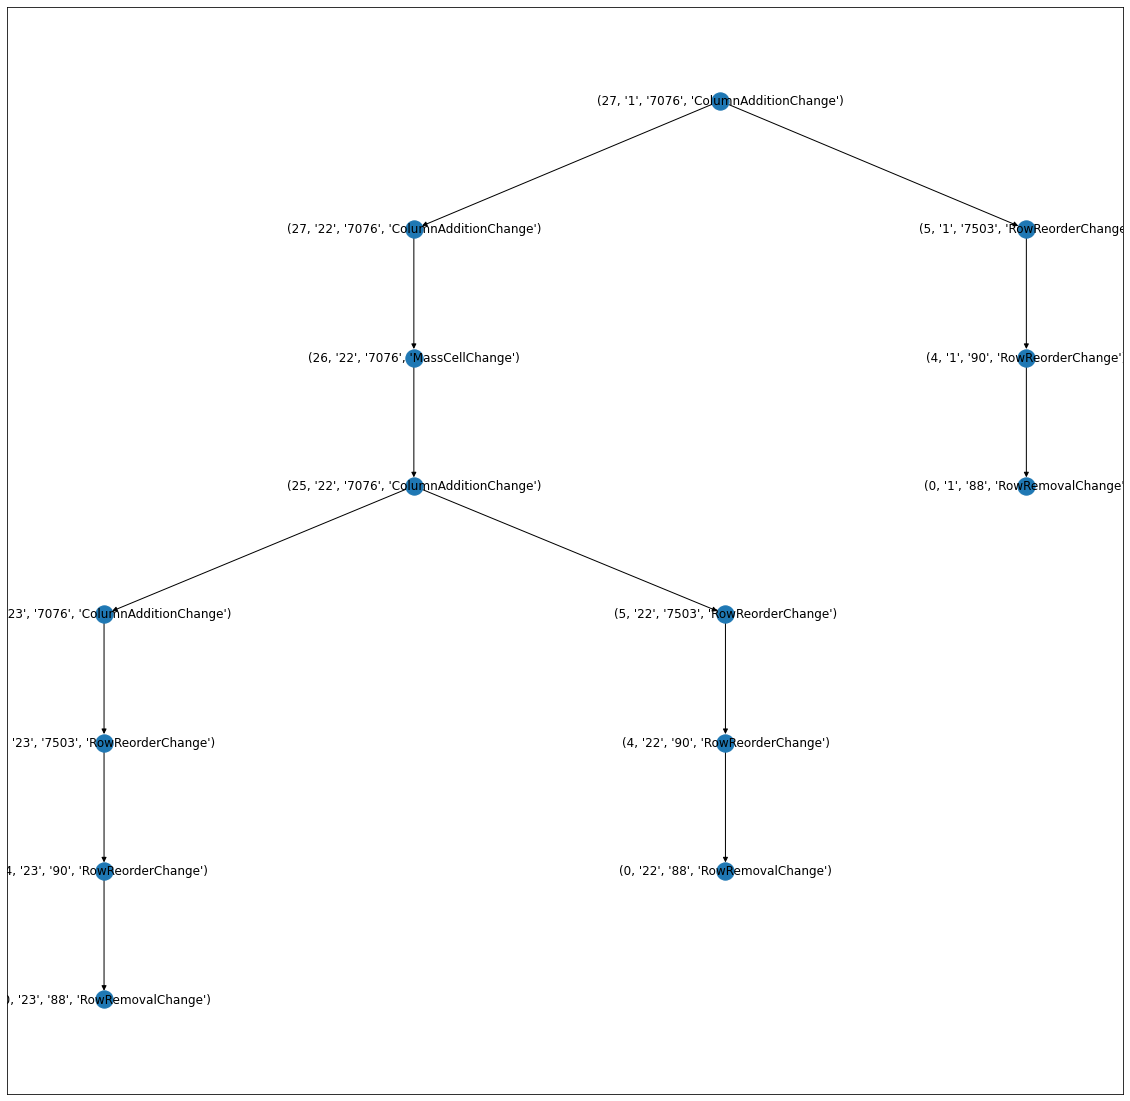

In [62]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
pos = nx.nx_pydot.graphviz_layout(ngraph,prog="dot")
nx.draw_networkx(ngraph,pos=pos)

In [59]:
def history_cell(col_id,row_id,start_seq=0,latest_value="",start_row_id=None,old_cell=None,ngraph=None,temp_cell=None):
    #print("cell trace",col_id,row_id,start_seq)
    if start_row_id==None:
        start_row_id = row_id

    old_value = latest_value    

    if latest_value=="":
    #if start_seq==0:
        latest_value = dataset[2]["rows"][int(row_id)]["cells"][int(col_id)]
        #print("cell trace",col_id,row_id,start_seq,"latest value:",latest_value)
    
    #if old_cell == None:
    #    old_cell = (col_id,row_id,latest_value)
            
    x, y = search_cell_column(dataset[0]["cols"],col_id)
    #print(min(dataset[2]["rows"].keys()))
    #print("cell trace",col_id,row_id,start_seq,"latest value:",dataset[2]["rows"][int(row_id)]["cells"][int(col_id)])
    q1 = c.execute("""
    select * from (
    select seq_id,old_col,'col_changes',history_id,op_name from col_changes where new_col = ? and seq_id>=?
    UNION
    select seq_id,old_row,'row_changes',history_id,op_name from row_changes where new_row = ? and seq_id>=?
    ) 
    order by seq_id asc limit 1
    """,(str(col_id),str(start_seq),str(row_id),str(start_seq)))

    xx = [x for x in q1]
    if len(xx)>0:
        xx = xx[0]        
        #print(xx)
        change_seq = xx[0]
        change_cc = xx[1]
        change_type = xx[2]
        op_name = xx[4]
    else:
        change_seq = 9999999
        change_type = None
        op_name = ""

    q2 = c.execute("""
    select * from cell_changes where cell_id=? and row_id=? and seq_id>=? and seq_id<? order by seq_id asc
    """,(str(col_id),str(row_id),str(start_seq),str(change_seq)))
    
    
    all_result = [x for x in q2]
    #print(all_result)

    if len(all_result)>0:
        old_value = latest_value
        latest_value = all_result[-1][6]
        #print("cell trace",col_id,row_id,start_seq,"latest value:",latest_value)
    #else:
    #    all_result = all_result + [(start_seq,"","",col_id,row_id,latest_value)]
        print("tcell",temp_cell)
        if temp_cell!=None:
            print("tt5",temp_cell)
            ngraph.add_edge((temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1],str(old_value)),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1],str(latest_value)))
        for j,x in enumerate(all_result):
            if (j==0) & (temp_cell!=None):
                print("tt6",(x[0],x[4],x[3]),(temp_cell[0],temp_cell[1],temp_cell[2]))
                ngraph.add_edge((x[0],x[4],x[3],all_recipe[x[0]][1],str(old_value)),(temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1],str(latest_value)))
            else:
                print("tt3",(x[0],x[4],x[3]),(old_cell[0],old_cell[1],old_cell[2]))
                ngraph.add_edge((x[0],x[4],x[3],all_recipe[x[0]][1],str(old_value)),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1],str(latest_value)))
            old_cell = (x[0],x[4],x[3],x[6],x[2])
            #change_seq = x[0]
            #col_id = x[4]
            #row_id = x[3]
            #latest_value = x[6]
        new_cell = old_cell
    else:
        new_cell = (change_seq,col_id,row_id,latest_value,op_name)

    print("moving cell",old_cell,new_cell)
    if ngraph!=None:        
        if (old_cell!=None) & (start_seq>0):
            #ngraph.add_edge((old_cell[0],old_cell[1]),(new_cell[0],new_cell[1]))
            print("tt1",(new_cell[0],new_cell[1],new_cell[2]),(old_cell[0],old_cell[1],old_cell[2]))
            if (new_cell[0]==9999999) & (temp_cell!=None):
                ngraph.add_edge((temp_cell[0],temp_cell[1],temp_cell[2],all_recipe[temp_cell[0]][1],str(old_value)),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1],str(latest_value)))
            else:
                ngraph.add_edge((new_cell[0],new_cell[1],new_cell[2],all_recipe[new_cell[0]][1],str(old_value)),(old_cell[0],old_cell[1],old_cell[2],all_recipe[old_cell[0]][1],str(latest_value)))

    #elif latest_value=="":
    # first time, no change on cell_changes, set latest_value as

    q3 = c.execute("""
    select seq_id,col_dep from col_dependency where col=? and seq_id>=? and seq_id<? order by seq_id asc
    """,(str(col_id),str(start_seq),str(change_seq)))

    #print("seq_dep",[x for x in q3])
    for x in q3:
        print("column dependency:",x[0])
        #all_result = all_result + history_cell(x[0],row_id,change_seq)
        try:
            forward_res = forward_history(x[1],row_id,start_seq)[-1]
            #ngraph.add_edge((new_cell[0],new_cell[1]),(x[0],row_id))
            print("tt2",(x[0],x[1],row_id),(new_cell[0],new_cell[1],new_cell[2]))
            ngraph.add_edge((x[0],x[1],row_id,all_recipe[x[0]][1],str(old_value)),(new_cell[0],new_cell[1],new_cell[2],all_recipe[new_cell[0]][1],str(latest_value)))
            temp_cell = (x[0],x[1],row_id,latest_value,op_name)
        except:
            break
        new_cell=temp_cell
        print("temp_cell",new_cell)
        #print(forward_res)
        #all_result = all_result + history_cell(x[0],start_row_id,0,start_row_id=start_row_id,old_cell=new_cell)
        all_result = all_result + history_cell(forward_res[1][2][0],forward_res[1][2][1],0,start_row_id=start_row_id,old_cell=new_cell,ngraph=ngraph,temp_cell=temp_cell)
        print(all_result)
        yy = all_result[1]
        #print("tt4",((yy[0],yy[4],yy[3]),temp_cell[0],temp_cell[1],temp_cell[2]))
        #ngraph.add_edge((yy[0],yy[4],yy[3]),(temp_cell[0],temp_cell[1],temp_cell[2]))
        new_cell = (yy[0],yy[4],yy[3],yy[4],yy[2])

    if change_type=="col_changes":
        col_id = change_cc
        #print("col_changes:",col_id,row_id,latest_value)        
    elif change_type=="row_changes":
        row_id = change_cc
        #print("row_changes:",col_id,row_id,latest_value)        
        #print([x for x in q1]        
    else:
        pass
    
    #
    #if len(xx)>0:
    #    print(list(xx) + [latest_value])        

    # dependency for the column

    if change_seq!=9999999:
        all_result = all_result + history_cell(col_id,row_id,change_seq+1,latest_value,start_row_id=start_row_id,old_cell=new_cell,ngraph=ngraph,temp_cell=temp_cell)

    return all_result

#print("\n".join([str(x) for x in history_cell(col_id,row_id)]))

In [55]:
ngraph = nx.DiGraph()

In [56]:
ngraph = nx.DiGraph()
col_id="23"
row_id="88"
test = history_cell(col_id,row_id,ngraph=ngraph)
print("change values")
print("\n".join([str(x) for x in test]))

moving cell None (0, &#39;23&#39;, &#39;88&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowRemovalChange&#39;)
moving cell (0, &#39;23&#39;, &#39;88&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowRemovalChange&#39;) (4, &#39;23&#39;, &#39;90&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowReorderChange&#39;)
tt1 (4, &#39;23&#39;, &#39;90&#39;) (0, &#39;23&#39;, &#39;88&#39;)
moving cell (4, &#39;23&#39;, &#39;90&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowReorderChange&#39;) (5, &#39;23&#39;, &#39;7503&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}, &#39;com.google.refine.model.changes.RowReorderChange&#39;)
tt1 (5, &#39;23&#39;, &#39;7503&#39;) (4, &#39;23&#39;, &#39;90&#39;)
tcell None
tt3 (25,

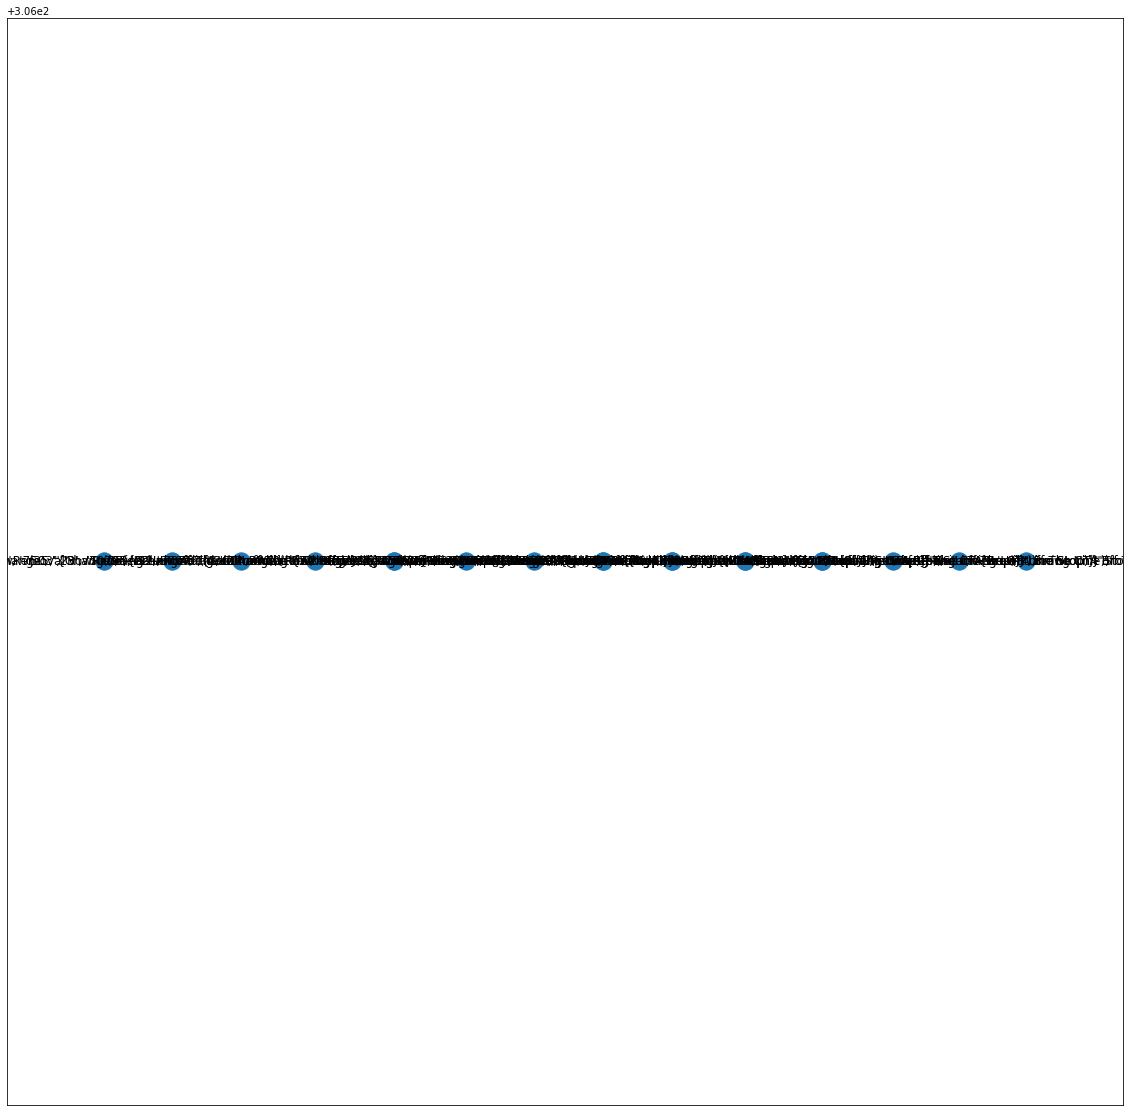

In [57]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
pos = nx.nx_pydot.graphviz_layout(ngraph,prog="dot")
nx.draw_networkx(ngraph,pos=pos)

moving cell None (23, 88, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;})
moving cell (23, 88, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}) (23, &#39;90&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;})
moving cell (23, &#39;90&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}) (23, &#39;7503&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;})
moving cell (23, &#39;7503&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}) (23, &#39;7076&#39;, &quot;{&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}&quot;)
column dependency: 22
2 (&#39;22&#39;, &#39;90&#39;) (&#39;22&#39;, &#39;88&#39;)
moving cell (23, &#39;7076&#39;, &quot;{&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;}&quot;) (&#39;22&#39;, &#39;88&#39;, {&#39;v&#39;: &#39;Stunning Unit off The CTA Brown Line Stop&#39;})
moving cell (&#39;22&#39;, &#39;88&#39;, {&#39;v

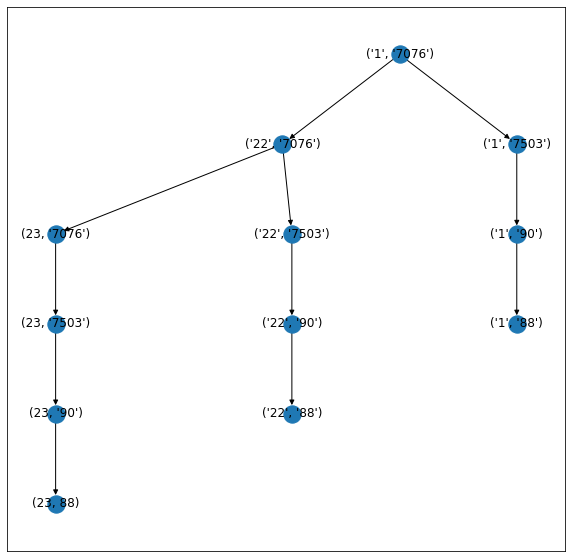

In [7]:
from matplotlib import pyplot as plt

ngraph = nx.DiGraph()
col_id=23
row_id=88
test = history_cell(col_id,row_id,ngraph=ngraph)
plt.figure(figsize=(10,10))
pos = nx.nx_pydot.graphviz_layout(ngraph,prog="dot")
nx.draw_networkx(ngraph,pos=pos)